# Car Price Prediction::

Download dataset from this link:

https://www.kaggle.com/hellbuoy/car-price-prediction

# Problem Statement::

A Chinese automobile company Geely Auto aspires to enter the US market by setting up their manufacturing unit there and producing cars locally to give competition to their US and European counterparts.

They have contracted an automobile consulting company to understand the factors on which the pricing of cars depends. Specifically, they want to understand the factors affecting the pricing of cars in the American market, since those may be very different from the Chinese market. The company wants to know:

Which variables are significant in predicting the price of a car
How well those variables describe the price of a car
Based on various market surveys, the consulting firm has gathered a large data set of different types of cars across the America market.

# task::
We are required to model the price of cars with the available independent variables. It will be used by the management to understand how exactly the prices vary with the independent variables. They can accordingly manipulate the design of the cars, the business strategy etc. to meet certain price levels. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

# WORKFLOW ::

1.Load Data

2.Check Missing Values ( If Exist ; Fill each record with mean of its feature )

3.Split into 50% Training(Samples,Labels) , 30% Test(Samples,Labels) and 20% Validation Data(Samples,Labels).

4.Model : input Layer (No. of features ), 3 hidden layers including 10,8,6 unit & Output Layer with activation function relu/tanh (check by experiment).

5.Compilation Step (Note : Its a Regression problem , select loss , metrics according to it)

6.Train the Model with Epochs (100) and validate it

7.If the model gets overfit tune your model by changing the units , No. of layers , activation function , epochs , add dropout layer or add Regularizer according to the need .

8.Evaluation Step

9.Prediction

In [ ]:
# mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import dependencies 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# load data
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/CarPrice_Assignment.csv')
dataset.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [ ]:
# features format
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [ ]:
dataset.shape

(205, 26)

## Exploratory Data Analysis

In [ ]:
# symboling category is from -2 (least risky) to +3 (most risky), most cars are in 0-2 range
dataset['symboling'].astype('category').value_counts()

0     67
1     54
2     32
3     27
-1    22
-2     3
Name: symboling, dtype: int64

In [ ]:
# aspiration: An (internal combustion) engine property showing whether the oxygen intake is through
# standard (atmospheric pressure) or through turbocharging (pressurised oxygen intake)
dataset['aspiration'].astype('category').value_counts()

std      168
turbo     37
Name: aspiration, dtype: int64

In [ ]:
# drivewheel categories count
dataset['drivewheel'].astype('category').value_counts()

fwd    120
rwd     76
4wd      9
Name: drivewheel, dtype: int64

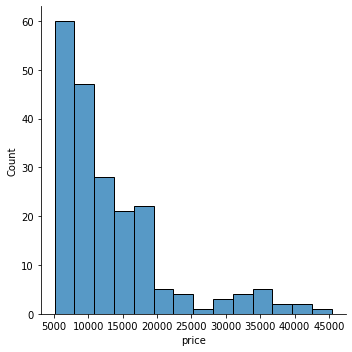

In [ ]:
# plot number of cars with their price
sns.displot(dataset['price'])
plt.show()

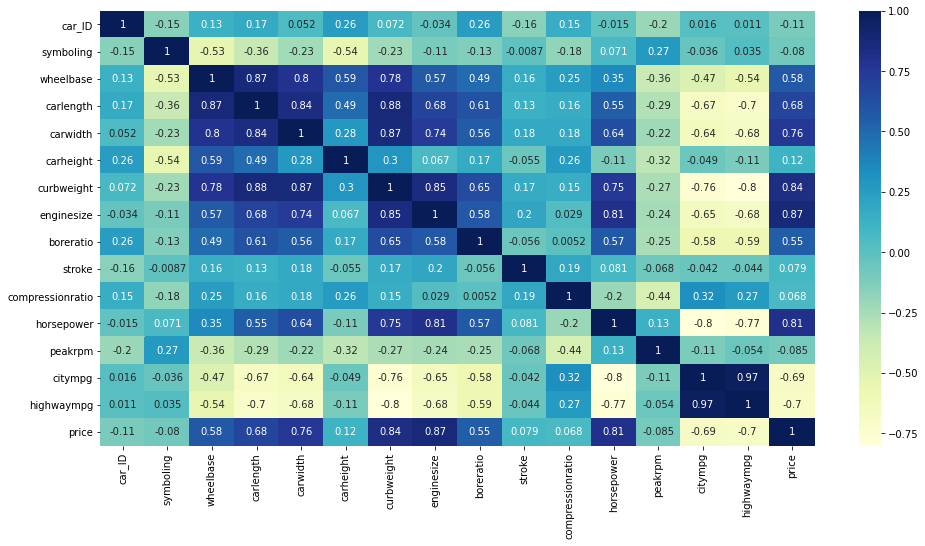

In [ ]:
# features correlations on a heatmap
# correlation matrix
cor = dataset.corr()

# figure size
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

In [ ]:
# statistical summary of all the quantitative features and check for outliers
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
car_ID,205.0,103.000000,59.322565,1.00,52.00,103.00,154.00,205.00
symboling,205.0,0.834146,1.245307,-2.00,0.00,1.00,2.00,3.00
wheelbase,205.0,98.756585,6.021776,86.60,94.50,97.00,102.40,120.90
carlength,205.0,174.049268,12.337289,141.10,166.30,173.20,183.10,208.10
carwidth,205.0,65.907805,2.145204,60.30,64.10,65.50,66.90,72.30
carheight,205.0,53.724878,2.443522,47.80,52.00,54.10,55.50,59.80
curbweight,205.0,2555.565854,520.680204,1488.00,2145.00,2414.00,2935.00,4066.00
enginesize,205.0,126.907317,41.642693,61.00,97.00,120.00,141.00,326.00
boreratio,205.0,3.329756,0.270844,2.54,3.15,3.31,3.58,3.94
stroke,205.0,3.255415,0.313597,2.07,3.11,3.29,3.41,4.17


## Data Cleaning

In [ ]:
# drop 'carID' feature, car id isn't helpful to predict a car's price
dataset = dataset.drop('car_ID', axis=1)

In [ ]:
dataset.shape

(205, 25)

In [ ]:
# 'symboling' is categorical but is treated as numeric, convert it to the right dtype
dataset['symboling'] = dataset['symboling'].astype('category', copy=False)

In [ ]:
# using regex for any alphanumeric combination before a space that may contain a hyphen (-)
import re

pat = re.compile(r'\w+-?\w+')
carnames = dataset['CarName'].apply(lambda x: re.findall(pat, x)[0])

# first 20 car names inthe dataset
carnames[:20]

0     alfa-romero
1     alfa-romero
2     alfa-romero
3            audi
4            audi
5            audi
6            audi
7            audi
8            audi
9            audi
10            bmw
11            bmw
12            bmw
13            bmw
14            bmw
15            bmw
16            bmw
17            bmw
18      chevrolet
19      chevrolet
Name: CarName, dtype: object

In [ ]:
# add new column 'car_company' inthe dataset
dataset['car_company'] = dataset['CarName'].apply(lambda x: re.findall(pat, x)[0])

In [ ]:
# replacing misspelled car_company names

# volkswagen
dataset.loc[(dataset['car_company'] == "vw") | 
         (dataset['car_company'] == "vokswagen"), 'car_company'] = 'volkswagen'

# porsche
dataset.loc[dataset['car_company'] == "porcshce", 'car_company'] = 'porsche'

# toyota
dataset.loc[dataset['car_company'] == "toyouta", 'car_company'] = 'toyota'

# nissan
dataset.loc[dataset['car_company'] == "Nissan", 'car_company'] = 'nissan'

# mazda
dataset.loc[dataset['car_company'] == "maxda", 'car_company'] = 'mazda'

In [ ]:
# number of cars 
dataset['car_company'].astype('category').value_counts()

toyota         32
nissan         18
mazda          17
honda          13
mitsubishi     13
subaru         12
volkswagen     12
volvo          11
peugeot        11
dodge           9
buick           8
bmw             8
plymouth        7
audi            7
saab            6
porsche         5
isuzu           4
alfa-romero     3
chevrolet       3
jaguar          3
renault         2
mercury         1
Name: car_company, dtype: int64

In [ ]:
# drop 'carname' feature and replace it with new feature 'car_company'
dataset = dataset.drop('CarName', axis=1)

In [ ]:
# find categorical features
dataset.select_dtypes(include=['object', 'category']).columns

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber',
       'fuelsystem', 'car_company'],
      dtype='object')

In [ ]:
# create one-hot encode for categorical features

def dummies(df,x):
  template = pd.get_dummies(df[x], drop_first=True)
  df = pd.concat([df, template], axis=1)
  df.drop([x], axis=1, inplace=True)
  return df

# apply categorical features in the function
dataset = dummies(dataset, 'symboling')
dataset = dummies(dataset, 'fueltype')
dataset = dummies(dataset, 'aspiration')
dataset = dummies(dataset, 'doornumber')
dataset = dummies(dataset, 'carbody')
dataset = dummies(dataset, 'drivewheel')
dataset = dummies(dataset, 'enginelocation')
dataset = dummies(dataset, 'enginetype')
dataset = dummies(dataset, 'fuelsystem')
dataset = dummies(dataset, 'cylindernumber')
dataset = dummies(dataset, 'car_company')

# view dataset
dataset.head()

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,-1,0,1,2,3,gas,turbo,two,hardtop,hatchback,sedan,wagon,fwd,rwd,rear,dohcv,l,ohc,ohcf,ohcv,rotor,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi,five,four,six,three,twelve,two,audi,bmw,buick,chevrolet,dodge,honda,isuzu,jaguar,mazda,mercury,mitsubishi,nissan,peugeot,plymouth,porsche,renault,saab,subaru,toyota,volkswagen,volvo
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
dataset.shape

(205, 69)

## Data Preprocessing

In [ ]:
# split dataset into input(X) and output(y)
X = dataset.loc[:, dataset.columns != 'price']
y = dataset.loc[:, dataset.columns == 'price']

In [ ]:
X.shape, y.shape

((205, 68), (205, 1))

In [ ]:
# split the data into 70% train set and 30% test set
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
train_features.shape, test_features.shape

((143, 68), (62, 68))

In [ ]:
train_labels.shape, test_labels.shape

((143, 1), (62, 1))

In [ ]:
# normalize the train and test features
pd.options.mode.chained_assignment = None     # default='warn'
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# choosing all numeric features
num_vars = ['wheelbase', 'carlength', 'carwidth', 'curbweight', 'enginesize',
            'boreratio', 'horsepower', 'citympg', 'highwaympg', 'carheight', 'stroke', 'compressionratio',
            'peakrpm']

train_features[num_vars] = scaler.fit_transform(train_features[num_vars])
test_features[num_vars] = scaler.fit_transform(test_features[num_vars])

In [ ]:
test_features.head()

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,-1,0,1,2,3,gas,turbo,two,hardtop,hatchback,sedan,wagon,fwd,rwd,rear,dohcv,l,ohc,ohcf,ohcv,rotor,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi,five,four,six,three,twelve,two,audi,bmw,buick,chevrolet,dodge,honda,isuzu,jaguar,mazda,mercury,mitsubishi,nissan,peugeot,plymouth,porsche,renault,saab,subaru,toyota,volkswagen,volvo
15,0.492711,0.714925,0.578947,0.642105,0.722222,0.599190,0.797753,0.701754,0.062500,0.842767,0.675676,0.057143,0.157895,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0.376093,0.553731,0.666667,0.252632,0.648839,0.283401,0.247191,0.707602,0.000000,0.704403,0.729730,0.057143,0.157895,0,1,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100,0.309038,0.482090,0.429825,0.536842,0.337479,0.238866,0.471910,0.748538,0.093750,0.308176,0.567568,0.371429,0.473684,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
132,0.364431,0.679104,0.543860,0.684211,0.485075,0.242915,0.707865,0.514620,0.144375,0.389937,0.594595,0.200000,0.315789,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
68,0.682216,0.743284,0.877193,0.957895,0.937811,0.493927,0.752809,0.847953,0.906250,0.471698,0.108108,0.228571,0.236842,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Build and Train Model

#### Baseline Model

In [ ]:
# model definition

def baseline_model():
  model = Sequential([
      Dense(10, activation='relu', input_shape=(train_features.shape[-1],)),
      Dense(8, activation='relu'),
      Dense(6, activation='relu'),
      Dense(1)])


  model.compile(optimizer='adam', loss='mae', metrics=['mse'])

  return model

In [ ]:
model = baseline_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                690       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 839
Trainable params: 839
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the model with 20% validation data and 100 epochs
history = model.fit(train_features, train_labels, validation_split=0.2, epochs=100, verbose=0)

In [ ]:
# store history inthe DataFrame
hist = pd.DataFrame(history.history)
hist.tail()

,loss,mse,val_loss,val_mse
95,12283.364258,204639648.0,13511.577148,268552832.0
96,12245.998047,203700992.0,13473.962891,267513680.0
97,12207.279297,202742048.0,13435.179688,266445264.0
98,12167.444336,201734928.0,13395.150391,265345856.0
99,12126.462891,200744288.0,13353.803711,264213056.0


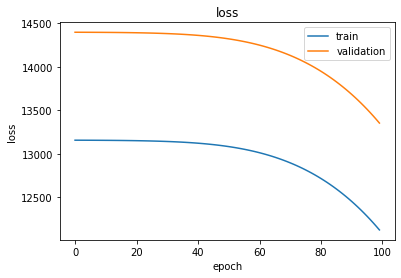

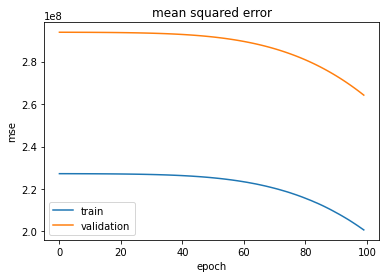

In [ ]:
# plot validation loss during training
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# plot mse during training
plt.plot(hist['mse'])
plt.plot(hist['val_mse'])
plt.title('mean squared error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

#### Second Model (smaller model size)

In [ ]:
# model with 2 layers and 64 nodes on each layer

def build_model2():
  model = Sequential([
      Dense(64, activation='relu', input_shape=(train_features.shape[-1],)),
      Dense(64, activation='relu'),
      Dense(1)])


  model.compile(optimizer='adam', loss='mae')

  return model

In [ ]:
model = build_model2()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                4416      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the model with 20% validation data on 500 epochs and earlystopping callback
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(train_features, train_labels, validation_split=0.2, epochs=500,
                   batch_size=64, verbose=0, callbacks=[es])

In [ ]:
# store history log
hist = pd.DataFrame(history.history)
hist.tail(1)

,loss,val_loss
499,2030.956787,2908.981689


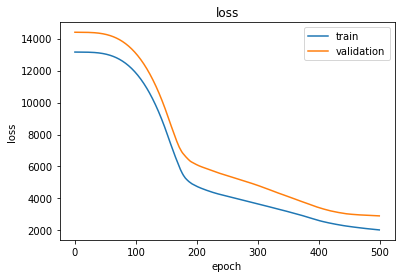

In [ ]:
# plot validation loss during training
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

#### Third Model (k-fold cross validation approach)

In [ ]:
# model definition with 2 layers, 32 nodes/layer and regularizer l1
from keras.regularizers import l1

def build_model3():
  model = Sequential([
      Dense(32, activation='relu', kernel_regularizer=l1(0.01), input_shape=(train_features.shape[-1],)),
      Dense(32, activation='relu', kernel_regularizer=l1(0.01)),
      Dense(1)])


  model.compile(optimizer='adam', loss='mae')

  return model

In [ ]:
model = build_model3()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                2208      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# split validation data with k-fold technique
k = 4
num_val_samples = len(train_features) // k

for i in range(k):
  print('processing fold #', i)
  # split validation set
  val_data = train_features[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]

  # concatenate remaining train set
  train_data = np.concatenate([train_features[:i * num_val_samples],
                                       train_features[(i + 1) * num_val_samples:]])
  train_targets = np.concatenate([train_labels[:i * num_val_samples],
                                          train_labels[(i + 1) * num_val_samples:]])

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [ ]:
# train the model with k-fold cross validation on 750 epochs and also with earlystopping
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)
history = model.fit(train_data, train_targets, validation_data=(val_data, val_targets),
                    epochs=750, batch_size=1, verbose=0, callbacks=[es])

Epoch 00271: early stopping


In [ ]:
# store history
hist = pd.DataFrame(history.history)
hist.tail(1)

,loss,val_loss
270,1092.080322,2027.553589


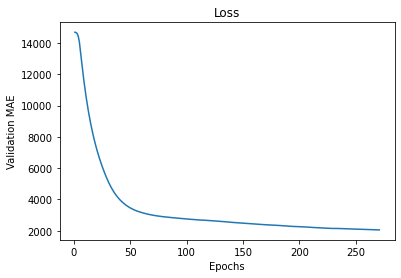

In [ ]:
# plot smooth curve of mae score on validation
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_history = smooth_curve(hist['val_loss'])
plt.plot(range(1, len(smooth_history) + 1), smooth_history)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

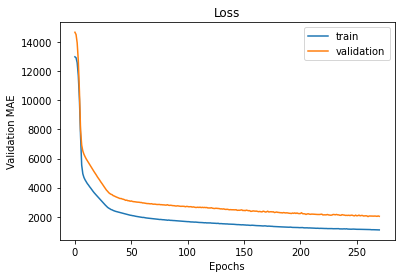

In [ ]:
# plot validation loss during training
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend(['train', 'validation'])

plt.show()

## Evaluation and Predictions on test set

In [ ]:
# evaluation on the test set
test_loss = model.evaluate(test_features, test_labels, verbose=0)
test_loss

2500.546630859375

In [ ]:
# make predictions
predictions = model.predict(test_features)

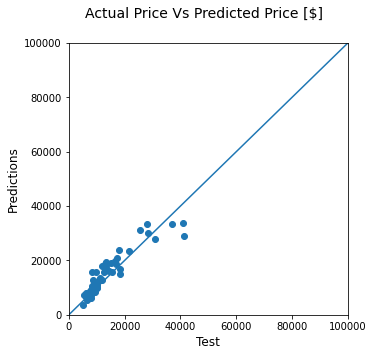

In [ ]:
# scatter plot of actual and predicted price
fig = plt.figure(figsize=(5,5))
plt.scatter(test_labels, predictions)
fig.suptitle('Actual Price Vs Predicted Price [$]', fontsize=14)             
plt.xlabel('Test', fontsize=12)                         
plt.ylabel('Predictions', fontsize=12)   
lims = [0, 100000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Save Model

In [50]:
# save model and architecture to single file
model.save("carprice.h5")
print("Saved model to disk")

Saved model to disk


## Load Model

In [52]:
from keras.models import load_model
# load model
model = load_model('carprice.h5')

# model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                2208      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


In [54]:
# evaluation on the same test set
model.evaluate(test_features, test_labels)

2/2 [==============================] - 0s 4ms/step - loss: 2500.5466


2500.546630859375

In [62]:
# price predictions
predictions =model.predict(test_features)
predictions.flatten()

array([27893.797 , 23886.246 , 11527.411 , 17929.262 , 30216.762 ,
        7542.881 ,  8428.119 ,  8412.455 ,  9911.986 ,  9171.66  ,
       17223.797 ,  8786.978 , 17003.896 , 10311.785 , 33628.69  ,
        5602.4136,  3674.9878, 15803.2   , 10477.82  , 11085.678 ,
       12625.176 , 19277.242 ,  9809.698 ,  5750.089 ,  7313.141 ,
       28832.148 , 15844.58  , 18240.094 ,  6361.5835, 18869.705 ,
       31104.545 ,  6730.5894,  7387.763 , 23333.293 ,  8930.871 ,
       33589.06  , 13471.098 , 12882.546 ,  9197.233 , 15983.99  ,
        8555.811 , 14943.14  , 15891.026 ,  6984.0425,  7637.096 ,
       11717.806 ,  6755.805 ,  6980.883 , 18532.895 , 16006.22  ,
        7998.9844, 19926.559 ,  7684.6235, 10716.531 ,  6338.3735,
       19103.738 , 15851.722 , 12882.546 , 33566.26  ,  7327.398 ,
       10629.4   , 20828.107 ], dtype=float32)

In [63]:
# actual price
actual = test_labels.values
actual.flatten()

array([30760.   , 17859.167,  9549.   , 11850.   , 28248.   ,  7799.   ,
        7788.   ,  9258.   , 10198.   ,  7775.   , 13295.   ,  8238.   ,
       18280.   ,  9988.   , 40960.   ,  6488.   ,  5151.   , 12629.   ,
        8189.   ,  9960.   ,  8495.   , 13499.   ,  8249.   ,  6479.   ,
        6692.   , 41315.   ,  9639.   , 13415.   ,  7999.   , 12940.   ,
       25552.   ,  6229.   ,  7898.   , 21485.   ,  7689.   , 28176.   ,
       11259.   , 10945.   ,  8916.5  , 14489.   ,  7463.   , 18344.   ,
       15580.   ,  6918.   ,  7499.   ,  9095.   ,  6229.   ,  7053.   ,
       16900.   , 12964.   ,  6295.   , 16558.   ,  7099.   ,  8948.   ,
        7349.   , 15250.   ,  8449.   , 11845.   , 37028.   ,  5389.   ,
        9233.   , 17199.   ])